# Task 1: Fine-tune Chemical Language Model

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [1]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random

#additional used dependencies:
#for simpler computing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#for ploting in evaluation
import numpy as np  
import matplotlib.pyplot as plt

#to remove additional prefixes
from collections import OrderedDict

d:\Users\Michael\anaconda3\envs\nnti\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [2]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [3]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

In [4]:
# Explore the dataset
# For example, print the column names and display a few sample rows
# TODO: your code goes here
#we first remove the "train" layer
compl_dataset = dataset['train']

#we print the data structure and some examples
print(f"The columns of the Dataset:", compl_dataset.column_names)
print(f"Number of samples in the Dataset:", len(compl_dataset))
print("The first 5 rows/samples of the Dataset:")
ex_data = pd.DataFrame(compl_dataset[:5])
print(ex_data)

The columns of the Dataset: ['SMILES', 'label']
Number of samples in the Dataset: 4200
The first 5 rows/samples of the Dataset:
                                              SMILES  label
0            Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14   3.54
1  COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...  -1.18
2             COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl   3.69
3  OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...   3.37
4  Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...   3.10


In [5]:
# define a PyTorch Dataset class for handling SMILES strings and targets
# TODO: your code goes here
class SMILESDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        #put the labels in a tensor for the model
        label = torch.tensor(self.dataset[idx]["label"], dtype=torch.float)
        
        #the SMILE stings first have to be tokenized for the model
        smiles = self.dataset[idx]["SMILES"]
        inputs_with_mask = self.tokenizer(
            smiles, 
            padding="max_length", 
            truncation=True, 
            return_tensors="pt", 
            max_length=128,
            return_attention_mask=True
        )
        
        #remove extra dimension
        input = inputs_with_mask["input_ids"].squeeze(0)
        attention_mask = inputs_with_mask["attention_mask"].squeeze(0)
        
        return input, attention_mask, label

## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [6]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

In [7]:
# split the data into training and test datasets
# TODO: your code goes here

#we want to have 0.7% for training; 0.1% for validation; 0.2% for testing
#first we split the dataset into testing and training & validation data
split_dataset = compl_dataset.train_test_split(test_size=0.2)

pre_train_val_dataset = split_dataset['train']
pre_test_dataset = split_dataset['test']

#we then additionally split into training and validation data
split_dataset_train_val = pre_train_val_dataset.train_test_split(test_size=0.125)

pre_train_dataset = split_dataset_train_val['train']
pre_val_dataset = split_dataset_train_val['test']

#we then also tokenize the datasets with our SMILESDataset-class
train_dataset = SMILESDataset(pre_train_dataset, tokenizer)
validation_dataset = SMILESDataset(pre_val_dataset, tokenizer)
test_dataset = SMILESDataset(pre_test_dataset, tokenizer)

In [8]:
# construct Pytorch data loaders for both train and test datasets
BATCH_SIZE = 32 # adjust based on memory constraints
# TODO: your code goes here
#we simply define DataLoader for training, validation and testing
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


## --- Step 3: Load Model ---

In [9]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

In [10]:
# We need to add a regression head on the language model as we are doing a regression task.
# specify model with a regression head
class MoLFormerWithRegressionHead(nn.Module):
    # TODO: your code goes here
    def __init__(self, curr_model):
        #to behave like a PyTorch-model, we super
        super(MoLFormerWithRegressionHead, self).__init__()
        self.model = curr_model
        #a single linear layer we use for the regression head
        #768 is common for transformers
        self.regression_head = nn.Linear(768, 1)
        
    def forward(self, input, attention_masks):
        #first get results after final hidden layer of the MolFormer-model
        outputs_molformer = self.model(input_ids=input, attention_mask=attention_masks)
        pooled_output = outputs_molformer.last_hidden_state[:, 0, :]
        
        #then additionally run our defined regression head for final model output
        regression_output = self.regression_head(pooled_output)
        
        return regression_output.squeeze(-1)
    

In [11]:
# initialize the regression model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

## --- Step 4: Training ---

In [12]:
# TODO: your code goes here
#we define a function for training a model with regression head
def train_model(regression_model, train_dataloader, validation_dataloader, lr=2e-5, epochs=30, patience=5, early_stopping=True, mlm=False):
    #standart optimizer and loss for transformers and regression
    optimizer = torch.optim.AdamW(regression_model.parameters(), lr=lr, weight_decay=0.5)
    criterion = nn.MSELoss()
    
    #we use the validation loss for early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    #we store all losses for evaluation
    all_train_losses = []
    all_val_losses = []
    
    #to count how many epochs we trained with early stopping
    count = epochs

    for epoch in range(epochs):
        #additionally compute avg loss for each epoch for evaluation
        regression_model.train()
        total_train_loss = 0
        
        #for each epoch run trough all trainingssamples
        for input, attention_mask, labels in train_dataloader:
            #for each trainingssample run forward and backpropagate trough our model
            input = input.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            #run forward
            outputs = regression_model(input = input, attention_masks=attention_mask)
            
            #compute training-loss and backpropagate
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #sum up training-losses in epoch
            total_train_loss += loss.item()
        
        #compute and store avg training-loss for every epoch
        avg_train_loss = total_train_loss / len(train_dataloader)
        all_train_losses.append(avg_train_loss)
        
        #validation loop:
        #use the model on the validation set
        regression_model.eval()
        val_loss = 0

        with torch.no_grad():
            for input, attention_mask, labels in validation_dataloader:
                input = input.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)
                
                #compute predictions for validation samples
                outputs = regression_model(input=input, attention_masks=attention_mask)
                loss = criterion(outputs, labels)
                
                #sum up validation-losses
                val_loss += loss.item()

        #compute and store avg validation-loss for every epoch
        avg_val_loss = val_loss / len(validation_dataloader)
        all_val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss}, Val Loss = {avg_val_loss:}")
        
        #check for early stopping
        #if validation-loss isn't improving for 'patience'-epochs --> stop the training
        if avg_val_loss < best_val_loss:
            #if validation loss improves reset 'epochs with no improvement' and store current model
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            if mlm:
                torch.save(regression_model.state_dict(), "mlm_best_reg_model.pth")
            else:
                torch.save(regression_model.state_dict(), "best_reg_model.pth")
        else:
            #if validation loss doesn't improve, only increase 'epochs with no improvement'
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs.")
            
        if early_stopping:
            #check if we have enough 'epochs with no improvement' to stop
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                count = epoch+1
                break
    
    return all_train_losses, all_val_losses, count

#train our model with regression head
train_losses, val_losses, count = train_model(regression_model=regression_model, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader)
#use the model that generalizes best during training
regression_model.load_state_dict(torch.load("best_reg_model.pth", weights_only=True))
        

Epoch 1: Train Loss = 1.514455979285033, Val Loss = 0.9798859698431832
Epoch 2: Train Loss = 0.8559427044313886, Val Loss = 0.7107641398906708
Epoch 3: Train Loss = 0.6517278898669325, Val Loss = 0.6987352647951671
Epoch 4: Train Loss = 0.47801493075878726, Val Loss = 0.6624577130590167
Epoch 5: Train Loss = 0.401764763114245, Val Loss = 0.5546503514051437
Epoch 6: Train Loss = 0.35731874244368594, Val Loss = 0.5396991329533714
Epoch 7: Train Loss = 0.32546952464010404, Val Loss = 0.5559284921203341
No improvement for 1 epochs.
Epoch 8: Train Loss = 0.28851119331691577, Val Loss = 0.5327641630013075
Epoch 9: Train Loss = 0.2610767671595449, Val Loss = 0.44905227422714233
Epoch 10: Train Loss = 0.23075063518531944, Val Loss = 0.5466192556279046
No improvement for 1 epochs.
Epoch 11: Train Loss = 0.22747090110636276, Val Loss = 0.5187506420271737
No improvement for 2 epochs.
Epoch 12: Train Loss = 0.1975992140562638, Val Loss = 0.569402990596635
No improvement for 3 epochs.
Epoch 13: Tra

<All keys matched successfully>

## --- Step 5: Evaluation ---

Mean Squared Error (MSE): 0.4910212457180023
Mean Absolute Error (MAE): 0.5289942622184753
R² Score: 0.6557571887969971
Margin for Median: 0.42002663


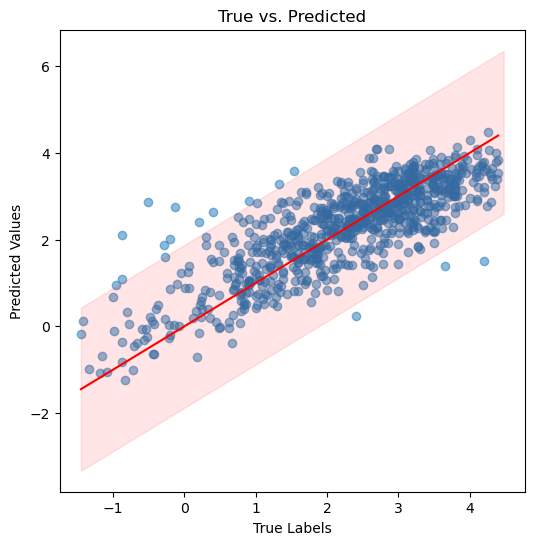

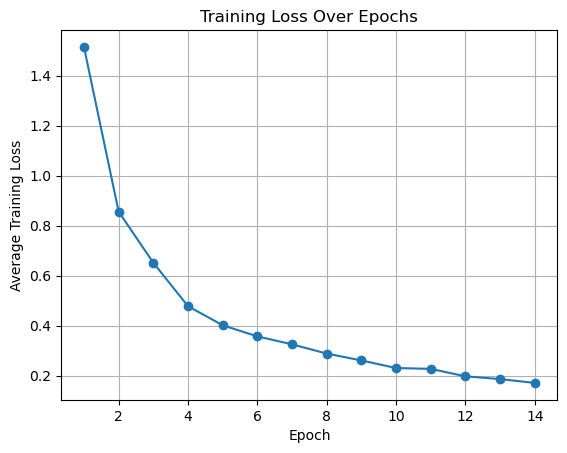

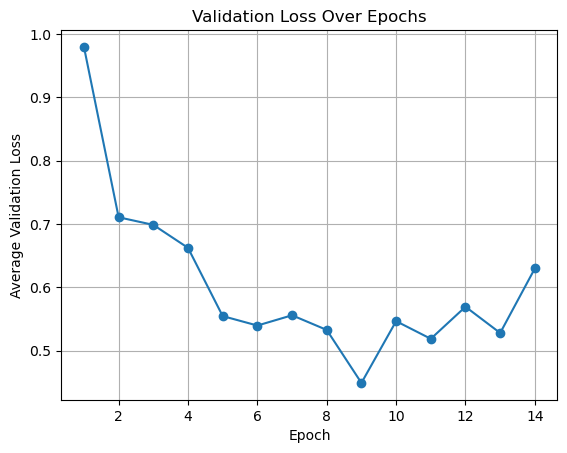

In [13]:
# TODO: your code goes here
#function to compute mse, mae and r2-score of a model on our dataset
def evaluate_model(regression_model, test_dataloader):
    
    regression_model.eval()
    all_preds = []
    all_labels = []

    #first we collect all labels and predictions of the test-set for different performance metrics
    for input, attention_mask, labels in test_dataloader:
        input = input.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
            
        #compute predictions for our test-dataset
        outputs = regression_model(input=input, attention_masks=attention_mask)
        
        #store all predictions and labels
        all_preds.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    #compute the MSE, the MAE and the R2-score
    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)
    
    return mse, mae, r2, all_preds, all_labels
    
#evaluate our model with regression head
mse, mae, r2, all_preds, all_labels = evaluate_model(regression_model=regression_model, test_dataloader=test_dataloader)

#comute the median of the absolute errors as a margin for the ideal prediction line
def compute_margin(labels, predictions):
    errors = np.abs(predictions - labels)
    margin = np.median(errors)
    return margin

#compute min of labels and max of predictions for plotting the margins
x_min, x_max = min(all_labels), max(all_preds)

#compute margins for median of the points
margin = compute_margin(all_labels, all_preds)

#print our result-scores
print(f"Mean Squared Error (MSE):", mse)
print(f"Mean Absolute Error (MAE):", mae)
print(f"R² Score:", r2)
print(f"Margin for Median:", margin)

#we additionally plot predictions and labels to see how our regression model performs
plt.figure(figsize=(6, 6))
plt.scatter(all_labels, all_preds, alpha=0.5)
#additional ideal prediction line
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r')
#add the margin
plt.fill_between(
    [x_min, x_max], 
    [x_min - margin * x_max, x_max - margin * x_max], 
    [x_min + margin * x_max, x_max + margin * x_max], 
    color='red', alpha=0.1, label="Margin"
)
plt.xlabel("True Labels")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted")
plt.show()

#plot the average training-losses for each epoch of training
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

#plot the average validation-losses for each epoch of training
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Average Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.grid(True)
plt.show()


# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.


In [14]:
# TODO: your code goes here
#define data_collador for masking the SMILES-strings
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=True, 
    mlm_probability=0.15
)

#tokenize our dataset
def tokenize_function(examples):
    return tokenizer(examples["SMILES"], truncation=True, padding="max_length", max_length=128)
tokenized_dataset = compl_dataset.map(tokenize_function, batched=True)

#remove original SMILES column, to only keep tokenized inputs
#remove labels because we do unsupervised fine-tuning (MLM), which does not use labels
tokenized_dataset = tokenized_dataset.remove_columns(["SMILES", "label"])

#again first split our tokenized data into test and train & validation data
mlm_split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
mlm_train_val_dataset = mlm_split_dataset['train']
mlm_test_dataset = mlm_split_dataset['test']
#we then additionally split into training and validation data
mlm_split_dataset_train_val = mlm_train_val_dataset.train_test_split(test_size=0.125)
mlm_train_dataset = mlm_split_dataset_train_val['train']
mlm_val_dataset = mlm_split_dataset_train_val['test']

#construct DataLoaders with our defined masking for train, validation and test datasets
train_dataloader_masked = DataLoader(mlm_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_dataloader_masked = DataLoader(mlm_val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
test_dataloader_masked = DataLoader(mlm_test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)

#set up the original model with the MLM-objective
mlm_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)
mlm_model.to(device)

#TRAIN THE MLM-MODEL:
#Hyperparameters:              
epochs = 30
lr = 2e-5
patience=5

#for early stopping
best_val_loss = float('inf')
epochs_no_improve = 0
    
#standart optimizer and loss for transformers and multi-classification
optimizer = torch.optim.AdamW(mlm_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
mlm_model.train()

for epoch in range(epochs):
    #for each epoch run trough all trainingssamples
    for batch in train_dataloader_masked:
        #for each trainingsample run forward and backpropagate trough our model
        input = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        if "labels" in batch:
            labels = batch["labels"].to(device)
        labels[labels == tokenizer.pad_token_id] = -100
        
        optimizer.zero_grad()
        
        #run forward
        outputs = mlm_model(input_ids = input, attention_mask=attention_mask)

        #flatten the logits and labels
        logits_flat = outputs.logits.view(-1, outputs.logits.size(-1))
        labels_flat = labels.view(-1)
        
        #compute loss and backpropagate
        loss = criterion(logits_flat, labels_flat) 
        loss.backward()
        optimizer.step()
    
    #Validation loop:
    mlm_model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader_masked:
            #for each validationsample run forward and compute loss
            input = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            if "labels" in batch:
                labels = batch["labels"].to(device)
            labels[labels == tokenizer.pad_token_id] = -100
                
            #run forward
            outputs = mlm_model(input_ids = input, attention_mask=attention_mask)

            #flatten the logits and labels
            logits_flat = outputs.logits.view(-1, outputs.logits.size(-1))
            labels_flat = labels.view(-1)
            
            #compute loss
            loss = criterion(logits_flat, labels_flat)
            val_loss += loss.item()

    #average loss for this epoch
    avg_val_loss = val_loss / len(val_dataloader_masked)
    
    print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:}")
        
    #early stopping check
    #if validation-loss isn't improving for 'patience'-epochs --> stop the training
    if avg_val_loss < best_val_loss:
        #if validation loss improves reset 'epochs with no improvement' and store current model
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(mlm_model.state_dict(), "best_mlm_model.pth")
    else:
        #if validation loss doesn't improve, only increase 'epochs with no improvement'
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    #check if we have enough 'epochs with no improvement' to stop
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

#save the trained mlm-model that generalizes best
mlm_model.load_state_dict(torch.load("best_mlm_model.pth", weights_only=True))
tokenizer.save_pretrained("molformer_mlm")
mlm_model.save_pretrained("molformer_mlm")

Epoch 1: Val Loss = 0.27080247764076504
Epoch 2: Val Loss = 0.2481463455728122
Epoch 3: Val Loss = 0.1868599589381899
Epoch 4: Val Loss = 0.20358006762606756
No improvement for 1 epochs.
Epoch 5: Val Loss = 0.16447349850620543
Epoch 6: Val Loss = 0.16322805466396467
Epoch 7: Val Loss = 0.1637914287192481
No improvement for 1 epochs.
Epoch 8: Val Loss = 0.14494173887318798
Epoch 9: Val Loss = 0.15420891903340816
No improvement for 1 epochs.
Epoch 10: Val Loss = 0.17375999316573143
No improvement for 2 epochs.
Epoch 11: Val Loss = 0.13723369920626283
Epoch 12: Val Loss = 0.12463781091251544
Epoch 13: Val Loss = 0.12903529512030737
No improvement for 1 epochs.
Epoch 14: Val Loss = 0.12393709072577101
Epoch 15: Val Loss = 0.13265582919120789
No improvement for 1 epochs.
Epoch 16: Val Loss = 0.13641768002084323
No improvement for 2 epochs.
Epoch 17: Val Loss = 0.17094737770301954
No improvement for 3 epochs.
Epoch 18: Val Loss = 0.14686923580510275
No improvement for 4 epochs.
Epoch 19: Val

# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.


In [15]:
# TODO: your code goes here
#again reload our pretrained mlm_model
mlm_model = AutoModel.from_pretrained("molformer_mlm", deterministic_eval=True, trust_remote_code=True)

#put the regression head on the pretrained mlm_model
mlm_regression_model = MoLFormerWithRegressionHead(mlm_model).to(device)

#since we can use the dataloaders from the first only regression-model, we can diectly start training
#we use the count for epochs and early_stopping=False to make sure we train the equal amount of epochs for both regression heads
mlm_train_losses, mlm_val_losses, _ = train_model(regression_model=mlm_regression_model, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, epochs=count, early_stopping=False, mlm=True)

#load the best model:
state_dict = torch.load("mlm_best_reg_model.pth", weights_only=True)

#if there is, remove the 'model.' prefix:
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("model.", "") 
    new_state_dict[new_key] = v

mlm_model.load_state_dict(new_state_dict, strict=False)


Epoch 1: Train Loss = 1.2214422825237978, Val Loss = 0.8221687291349683
Epoch 2: Train Loss = 0.7391514525465344, Val Loss = 0.6567487418651581
Epoch 3: Train Loss = 0.563188193284947, Val Loss = 0.5583514954362597
Epoch 4: Train Loss = 0.44334892151148425, Val Loss = 0.5151603030306953
Epoch 5: Train Loss = 0.37383897051863046, Val Loss = 0.5049531906843185
Epoch 6: Train Loss = 0.3369492413881032, Val Loss = 0.4682840747492654
Epoch 7: Train Loss = 0.2889505585088678, Val Loss = 0.5296908425433295
No improvement for 1 epochs.
Epoch 8: Train Loss = 0.2944694106345591, Val Loss = 0.45273943884032114
Epoch 9: Train Loss = 0.23921688767554966, Val Loss = 0.5403086308922086
No improvement for 1 epochs.
Epoch 10: Train Loss = 0.2193697774377854, Val Loss = 0.508787602186203
No improvement for 2 epochs.
Epoch 11: Train Loss = 0.2072987769446943, Val Loss = 0.404199335191931
Epoch 12: Train Loss = 0.180492687565477, Val Loss = 0.5111211176429477
No improvement for 1 epochs.
Epoch 13: Train L

_IncompatibleKeys(missing_keys=[], unexpected_keys=['regression_head.weight', 'regression_head.bias'])

              Metric  Original Model  MLM-pretrained Model
0                MSE        0.491021              0.443107
1                MAE        0.528994              0.497352
2           R² Score        0.655757              0.689348
3  Margin for Median        0.420027              0.384101


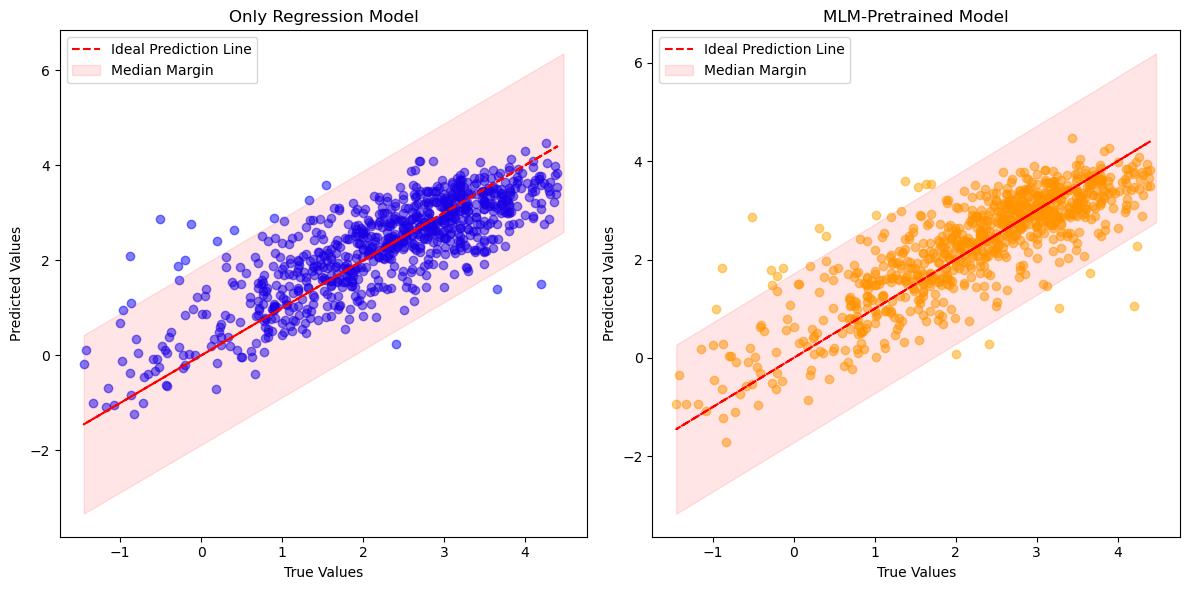

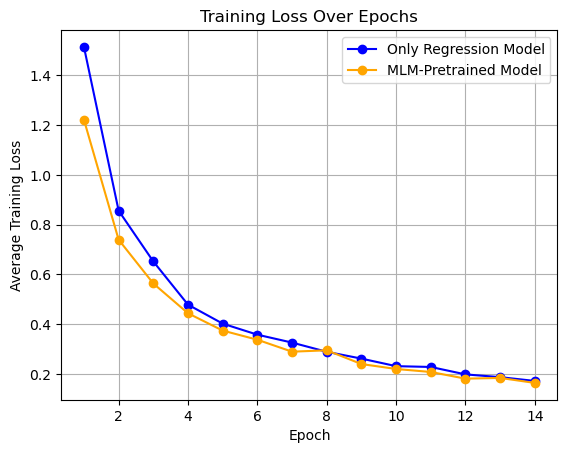

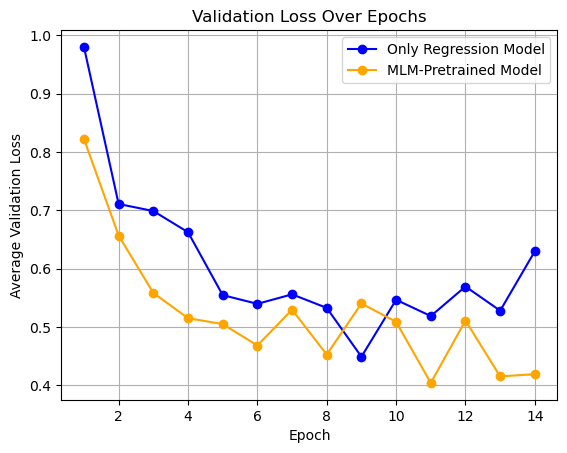

In [16]:
#evaluating and comparing the only finetuned regression model with the additional mlm-pretrained and finetuned regression model
mlm_mse, mlm_mae, mlm_r2, mlm_all_preds, mlm_all_labels = evaluate_model(regression_model=mlm_regression_model, test_dataloader=test_dataloader)
mse, mae, r2, all_preds, all_labels = evaluate_model(regression_model=regression_model, test_dataloader=test_dataloader)

#compute margins for median of the points
margin = compute_margin(all_labels, all_preds)
mlm_margin = compute_margin(mlm_all_labels, mlm_all_preds)

#compute min of labels and max of predictions for plotting the margins
x_min, x_max = min(all_labels), max(all_preds)
mlm_x_min, mlm_x_max = min(mlm_all_labels), max(mlm_all_preds)

#plot each model next to each other
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(all_labels, all_preds, alpha=0.5, color="blue")
#ideal prediction line with margin of median
axes[0].plot(all_labels, all_labels, 'r--', label="Ideal Prediction Line")
#add the margin
axes[0].fill_between(
    [x_min, x_max], 
    [x_min - margin * x_max, x_max - margin * x_max], 
    [x_min + margin * x_max, x_max + margin * x_max], 
    color='red', alpha=0.1, label="Median Margin"
)
axes[0].set_title("Only Regression Model")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
axes[0].legend()

axes[1].scatter(mlm_all_labels, mlm_all_preds, alpha=0.5, color="orange")
#ideal prediction line
axes[1].plot(mlm_all_labels, mlm_all_labels, 'r--', label="Ideal Prediction Line")
#add the margin
axes[1].fill_between(
    [mlm_x_min, mlm_x_max], 
    [mlm_x_min - mlm_margin * mlm_x_max, mlm_x_max - mlm_margin * mlm_x_max], 
    [mlm_x_min + mlm_margin * mlm_x_max, mlm_x_max + mlm_margin * mlm_x_max], 
    color='red', alpha=0.1, label="Median Margin"
)
axes[1].set_title("MLM-Pretrained Model")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
axes[1].legend()

#create table for comparison of the metrics
metrics = pd.DataFrame({
    "Metric": ["MSE", "MAE", "R² Score", "Margin for Median"],
    "Original Model": [mse, mae, r2, margin],
    "MLM-pretrained Model": [mlm_mse, mlm_mae, mlm_r2, mlm_margin]
})

print(metrics)
plt.tight_layout()
plt.show()

#plot the average losses for each epoch of training for each model
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color="blue", label="Only Regression Model")
plt.plot(range(1, len(mlm_train_losses) + 1), mlm_train_losses, marker='o', linestyle='-', color="orange", label="MLM-Pretrained Model")
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.show()

#plot the average losses for each epoch of training for each model
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', linestyle='-', color="blue", label="Only Regression Model")
plt.plot(range(1, len(mlm_val_losses) + 1), mlm_val_losses, marker='o', linestyle='-', color="orange", label="MLM-Pretrained Model")
plt.xlabel("Epoch")
plt.ylabel("Average Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.show()

**Observations:** <br>
MLM-pretraining improves the model by providing a better initial representation of SMILES strings, leading to better performance. Especially for the first training epochs. <br>
Although the difference of the losses for the different models narrow over the training period, the MLM-pretrained model scores better in all final evaluation metrics.<br>
Adding MLM-pretraining looks to be beneficial in improving regression performance on this task.